# Load libraries needed

## statistical and visualization libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Libraries for wordcloud and highest frequency words for each predicted class on a comment

In [2]:
from nltk.stem import WordNetLemmatizer
import string

"""to pre-process text"""
import preprocessor as p
import re 
import contractions 
import nltk
from nltk import word_tokenize  
from nltk.corpus import stopwords 

from wordcloud import WordCloud
from collections import Counter

## Libraries for Models

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union

# Data - preprocessing & Feature Engineering

## Load train and test data

In [4]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/2017-18_BS_Tweets.csv", encoding='latin')

train.shape, test.shape

((159571, 8), (20094, 2))

### Number of null values in train data

In [5]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Number of texts without any labels

In [6]:
train[(train.toxic == 0) & (train.severe_toxic == 0) & (train.obscene == 0) & (train.threat == 0) & (train.insult == 0) & (train.identity_hate == 0)].shape


(143346, 8)

### Distribution of category labels for comments in train data

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
severe_toxic,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
obscene,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
insult,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
identity_hate,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


### Correlation among the comment categories

In [8]:
classes = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

### Number of train texts labelled in different categories

In [9]:
train[classes].sum()

obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

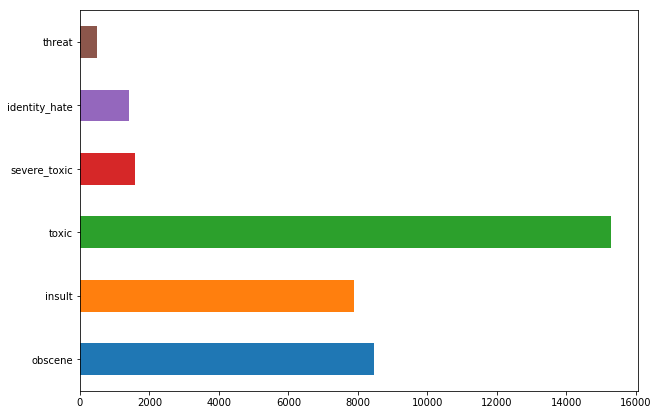

In [10]:
train[classes].sum().plot(kind = 'barh', figsize=(10, 7));
# plt.title()

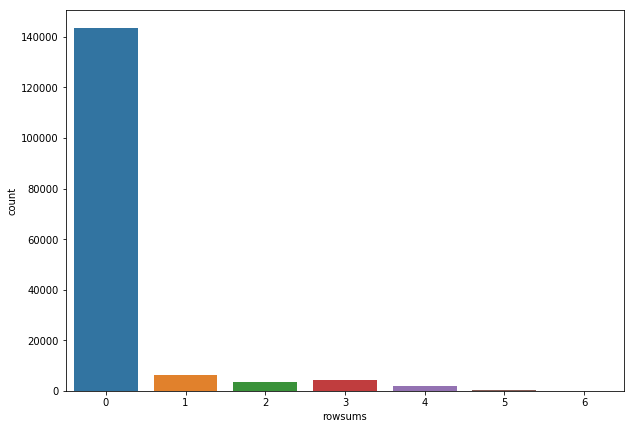

In [11]:
train['rowsums'] = train[classes].sum(axis=1)
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x= 'rowsums', data = train, ax=ax);

### Correlation between different classes

In [12]:
train[classes].corr()

,obscene,insult,toxic,severe_toxic,identity_hate,threat
obscene,1.000000,0.741272,0.676515,0.403014,0.286867,0.141179
insult,0.741272,1.000000,0.647518,0.375807,0.337736,0.150022
toxic,0.676515,0.647518,1.000000,0.308619,0.266009,0.157058
severe_toxic,0.403014,0.375807,0.308619,1.000000,0.201600,0.123601
identity_hate,0.286867,0.337736,0.266009,0.201600,1.000000,0.115128
threat,0.141179,0.150022,0.157058,0.123601,0.115128,1.000000


### heat map of correlations

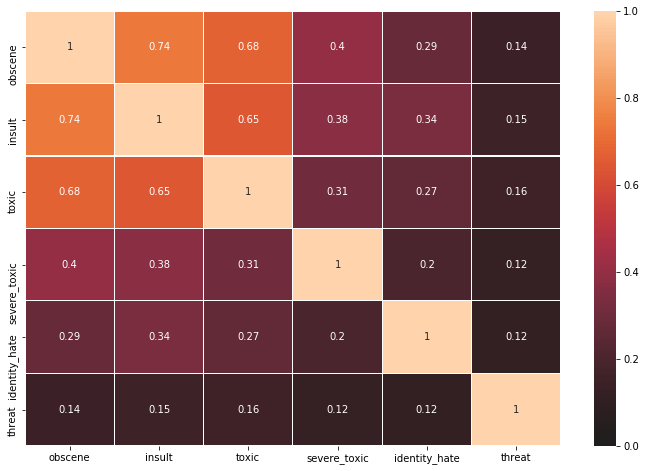

In [13]:
fig, ax = plt.subplots(figsize =(12, 8))
sns.heatmap(train[classes].corr(), vmin=0, vmax=1.0, center=0.0, linewidths=0.1, linecolor='white',annot=True, ax=ax); 

# Models

## Logistic regression with words and char n-grams

### Get the comments and tweets text

In [14]:
# all_text = pd.concat((train, test))
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat((train, test)).comment_text  # all_text.comment_text

### Initialize word and char vectorizers and join them using a pipeline

In [15]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=30000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)

union_vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)

### fit the vectorizer and generate the train and test features out of the text

In [16]:
union_vectorizer.fit(all_text)
train_features = union_vectorizer.transform(train_text)
test_features = union_vectorizer.transform(test_text)

### FIT the logistic regression MODEL, check CV score & predict the classes probability on test data

In [17]:
class_scores = []
predictions_log_reg = pd.DataFrame.from_dict({'id': test['id'], 'text': test['comment_text']})
for class_name in classes:
    train_classes = train[class_name]
    logreg_classifier = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(
        logreg_classifier, train_features, train_classes, cv=3, scoring='roc_auc'))
    class_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    logreg_classifier.fit(train_features, train_classes)
    predictions_log_reg[class_name] = logreg_classifier.predict_proba(test_features)[:, 1]

print('Total Average CV score is {}'.format(np.mean(class_scores)))

CV score for class obscene is 0.9906158106007341
CV score for class insult is 0.9830780254226337
CV score for class toxic is 0.9789945575833298
CV score for class severe_toxic is 0.9889033876547505
CV score for class identity_hate is 0.9832962478127246
CV score for class threat is 0.9888706458559681
Total CV score is 0.9856264458216901


# Visualizations

## Pre-process the tweet text and show the words most common in each of the classes in test data

### functions to pre-process the text

In [18]:
"""word Counter"""
def wordCounter(dfCol):
    d = Counter()
    dfCol.apply(lambda t: d.update(t.split()))    
    return pd.DataFrame.from_dict(d, orient='index').rename(columns={0: 'count'}).sort_values('count', ascending=False)

"""word cloud"""
def wordCloud(dictionary):
    return WordCloud(background_color='black', max_words=200, max_font_size=100, random_state=456).generate_from_frequencies(dictionary.to_dict()['count'])

"""Remove stop words"""
def remove_stopwords(text_list):
    words = []
    for word in text_list:
        if word not in stopwords.words('english'):
            words.append(word)
    return words

def normalizeText(text):
    lemmer = WordNetLemmatizer()
    
    text = p.clean(text) ## clean the text - removes emojis and urls
    text = re.sub('\[[^]]*\]', '', text)  ## removes all special characters
    text = contractions.fix(text)  ## to replace contracted words
    text = re.sub(r'[^\w\s]', '', text)  ## removes punctuation
    text_list = nltk.word_tokenize(text) ## tokenize the string
    text_list = remove_stopwords(text_list)
    text_list = [lemmer.lemmatize(word, 'v') for word in text_list]
    text_list = [text for text in text_list if text.lower() not in ('â', 'i', 'a', 'bodypositivity', 'body shaming', 'bodyshaming')] ## Generalised
    
    
    return text_list

### get tweets which have some specific probabiltity threshold of predicted classes

In [19]:
tweets_reg = {}
for clas in classes:
    prob = predictions_log_reg[clas].min()+0.2
    tweets_reg[clas] = predictions_log_reg[predictions_log_reg[clas] >= prob]['text']\
                                            .apply(lambda x: " ".join(normalizeText(x)))
    

## Visualizations for predictions

### pie chart of the distribution of classes on test data

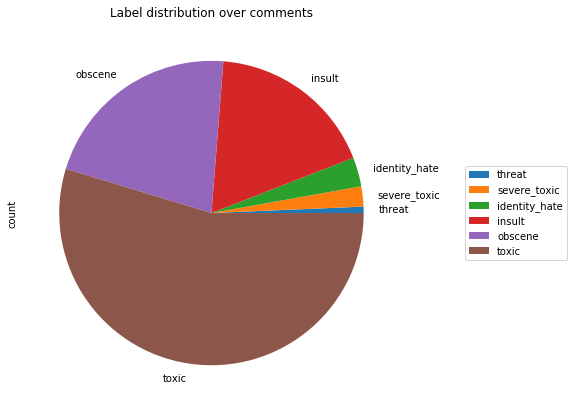

In [20]:
df_distribution = predictions_log_reg[classes].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
df_distribution.plot.pie(y='count', title='Label distribution over comments', figsize=(10, 7))\
                            .legend(loc='center', bbox_to_anchor=(1.3, 0.5));

### word clouds of most common text in each of the classes

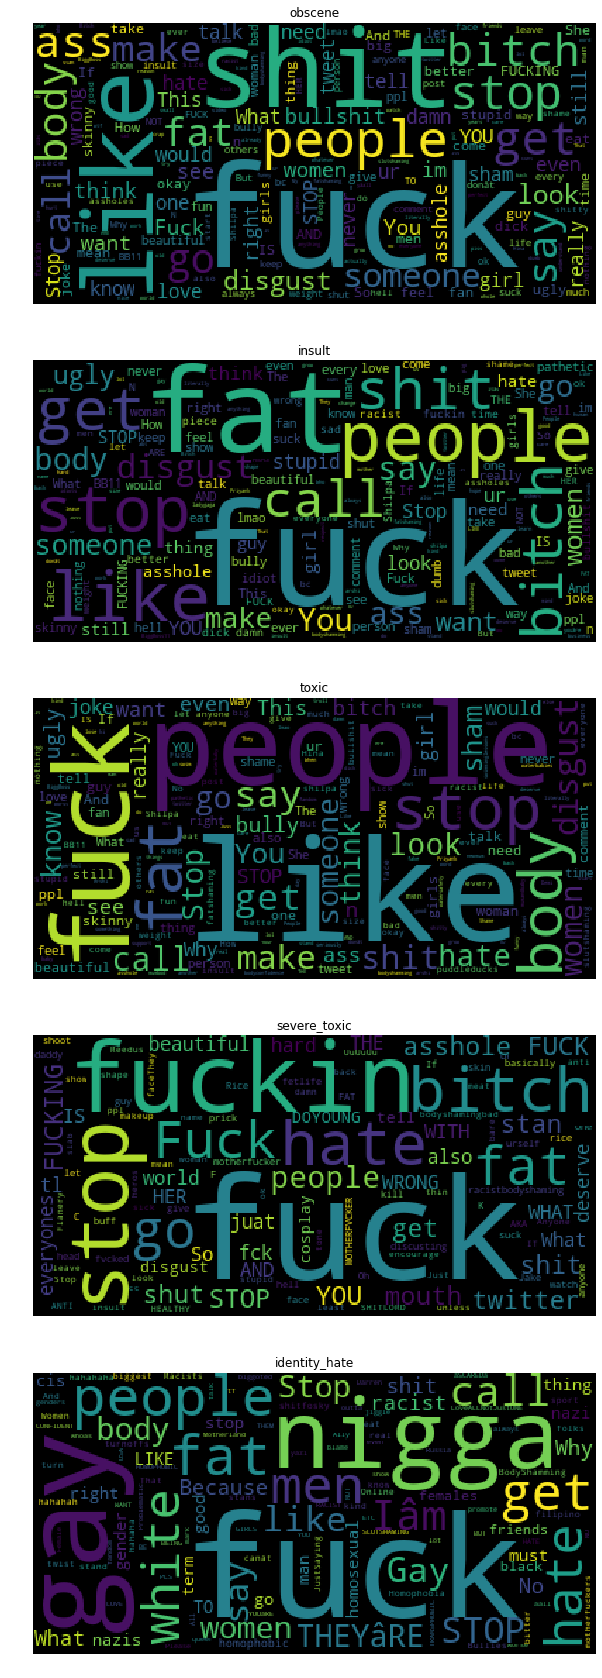

In [21]:
word_counter = {}
fig = plt.figure(figsize=(30, 30))
for clas, i in zip(classes, range(len(classes)-1)):
    word_counter[clas] = wordCounter(tweets_reg[clas])
    wc = word_counter[clas]  
    wordcloud = wordCloud(wc)
    ax =fig.add_subplot(len(classes)-1, 1, i + 1)
    ax.set_title(clas)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show();
    

### Distribution of probabilities of predicted classes

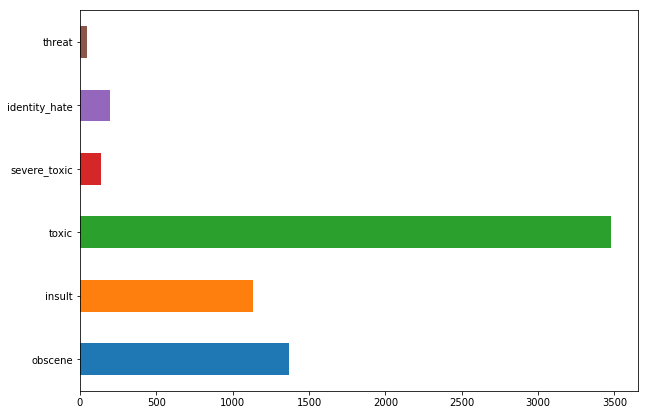

In [22]:
predictions_log_reg[classes].sum().plot(kind = 'barh', figsize=(10, 7));

### Heat map of correlation among the predicted classes

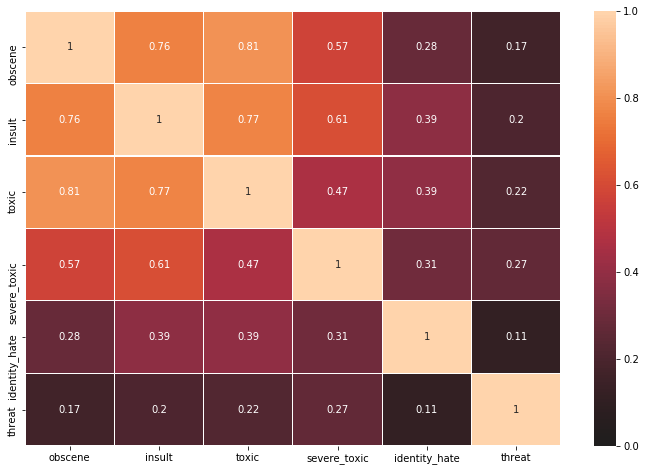

In [23]:
fig, ax = plt.subplots(figsize =(12, 8))
sns.heatmap(predictions_log_reg[classes].corr(), vmin=0, vmax=1.0, center=0.0, linewidths=0.1, linecolor='white',annot=True, ax=ax); 